### Predicting percentage change in multiple bacteria populations given their spreading factor

In [2]:
# Import libraries
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn import tree
import pydot
sns.set()

In [3]:
# Loading the data set 
df_training = pd.read_csv('data/bacteria_train.csv')

In [4]:
# Overview of data
df_training.head()

,Perc_population,Spreading_factor
0,1.535,0.190708
1,5.555,0.326928
2,-0.277,-0.459699
3,1.724,-0.193013
4,-0.550,-0.835745


Creating a scatter plot of the data points in the bacteria_train.csv file with the Spreading factor on the  𝑋 -axis and the Percentage change on the  𝑌 -axis.

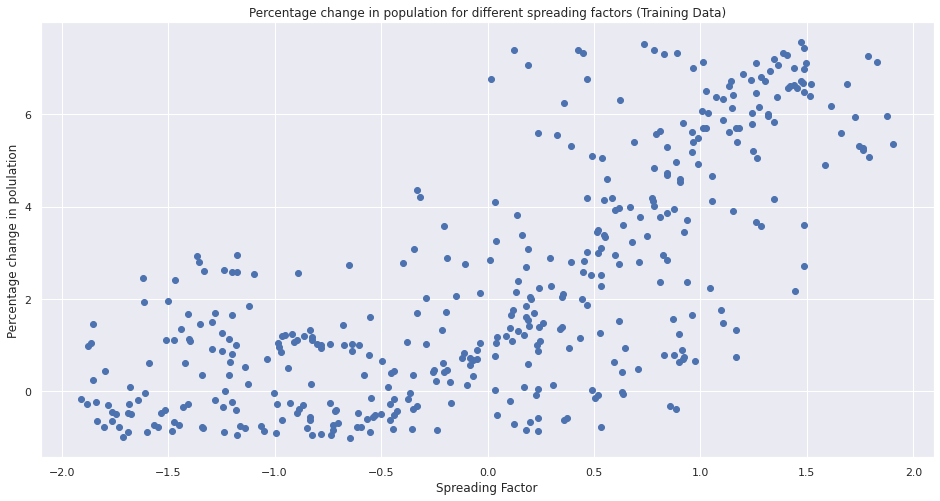

In [5]:
# Assigning Spreading factor to X and Percentage change to y variables respectively

X_training = df_training[['Spreading_factor']].values
y_training = df_training['Perc_population'].values

# Plotting pred vs res
plt.rcParams["figure.figsize"] = [16, 8]
plt.scatter(X_training, y_training)
plt.xlabel("Spreading Factor")
plt.ylabel("Percentage change in polulation")
plt.title("Percentage change in population for different spreading factors (Training Data)")
plt.show()

From the graphs we can conclude that for positive values of "Spreading Factor" percentage change in population is positive and increases linearly and for negative values of "Spreading facotor" the percentage change in population is on average negative and decreases linearly and reaches a limit very quickly.


Using k-fold cross validation with bootstrapping to find the best degrees

In [6]:
# Defining a bootstrap function

def bootstrap(df):
    selectionIndex = np.random.randint(len(df), size = len(df))
    new_df = df.iloc[selectionIndex]
    return new_df


#  Setting max degree of polynomial, number of bootstraps and initializing empty
#  lists which will be filled by the interations

maxdeg = 30
num_bootstraps = 50
best_degree = []

# Looping through each bootstrap

for i in range(num_bootstraps):
    
    df_new = bootstrap(df_training)
    
    # Splitting the data into predictor (X) and response (y) variables
    X, y   = df_new[['Spreading_factor']].values , df_new['Perc_population'].values

    # Splitting the data into training and validation set
    X_train, X_val, y_train, y_val = train_test_split(X,y,train_size=0.75, random_state= i)

    # Initializing empty lists to be filled 
    training_error = []
    validation_error = []
    
    # Looping through the degrees of polynomial

    for degree in range(1, maxdeg + 1 ):

        # Polynomial features for the entire data
        X_poly = PolynomialFeatures(degree).fit_transform(X)

        # Initializing Linear Regression 
        lreg = LinearRegression(fit_intercept=False) 
    
        # Perform cross-validation on the entire data
        mse_score = cross_validate(lreg, X_poly, y,cv=10, scoring="neg_mean_squared_error", return_train_score=True)

        # Taking average of the cross validation error and store in list 
        validation_error.append(-1*(np.mean(mse_score['test_score'])))
        training_error.append(-1*(np.mean(mse_score['train_score'])))
    
    min_val_mse = min(validation_error)
    best_val_degree = validation_error.index(min_val_mse)
    best_degree.append(best_val_degree + 1)





KeyboardInterrupt: 

In [ ]:
# Determining the most voted polynomial degree and its frequency
from statistics import mode
best_degree_overall = mode(best_degree)
frequency = 0
for i in best_degree:
    if i == best_degree_overall:
        frequency += 1

# Plotting the results
plt.rcParams["figure.figsize"] = [16, 8]
plt.hist(best_degree, bins=maxdeg, rwidth=1.0)
# Adding a bar graph on top of histogram to visually highlight the most voted polynomial
plt.bar(best_degree_overall,frequency,width=1.0,color='orange', align='center')
plt.rcParams["figure.figsize"] = [16, 8]
ticklabels = [i for i in range(1,maxdeg+1)]
plt.xticks(ticklabels)
plt.xlabel('Degree of Polynomial')
plt.ylabel('Best Degree Votes')
plt.title("Frequency of Polynomial Degrees selected as Best in bootstraps")
plt.show()

print(f"From the graph we can see that the most voted Polynomial Degree is {best_degree_overall} \nwith a total of {frequency} votes out of {num_bootstraps} bootstraps.")

We will choose 8 as the best_degree for the test set.

We se so much variance because the model is fitting the data for one perticular degree of polynomial i.e., the model is biased. Having high bias results in high variance and underfitting and having low bias results in low variance and overfitting.

Fitting the best model on the test data

# Loading the test data

df_test = pd.read_csv('data/bacteria_test.csv')
df_test.head()


In [ ]:
# Assigning Spreading factor to X and Percentage change to y variables respectively

X_test = df_test[['Spreading_factor']].values
y_test = df_test['Perc_population'].values

In [ ]:
# Training the model on train data using the best_degree we determined in above section

X_poly_training = PolynomialFeatures(best_degree_overall).fit_transform(X_training)
X_poly_test  = PolynomialFeatures(best_degree_overall).fit_transform(X_test)
lreg = LinearRegression() 
lreg.fit(X_poly_training, y_training)

# Predicting on test data
y_test_pred = lreg.predict(X_poly_test)

In [ ]:
# Mean Square error of the predictions
mse = mean_squared_error(y_test, y_test_pred)
print(f"The Mean Square Error of the predictions on test data is {mse:.4f} ")

In [ ]:
# Plotting the predictions along with the actual values

plt.scatter(X_test, y_test)
plt.scatter(X_test, y_test_pred)
plt.xlabel("Spreading Factor")
plt.ylabel("Percentage change in polulation")
plt.title("Percentage change in population for different spreading factors (Test Data)")
plt.legend(['Actual Data', 'Predicted Data'])
plt.show()

In [ ]:
# The Coefficients of the model
coefficients = lreg.coef_
print(f"The coefficients of the model are : \n {coefficients}")

## Improving consistency of the model

### Find the best hyperparameter alpha

In [ ]:
maxdeg = 30
alphas = [0.001, 0.005, 0.01, 0.015, 0.05, 0.1, 0.0, 14, 10, 100, 1000]
training_error, validation_error = [],[]
for i in alphas:
    X_poly_training = PolynomialFeatures(maxdeg).fit_transform(X_training)
    lasso_reg = Lasso(alpha=i)
    mse_score = cross_validate(lasso_reg, X_poly_training, y_training,cv=10, scoring="neg_mean_squared_error", return_train_score=True)
    validation_error.append(-1*(np.mean(mse_score['test_score'])))
    training_error.append(-1*(np.mean(mse_score['train_score'])))

In [ ]:
best_alpha_index = validation_error.index(min(validation_error))
best_alpha = alphas[best_alpha_index]
print(f"The best alpha value is : {best_alpha}")


### Finding the most significant degree

In [7]:
significant_degrees = {}
num_bootstraps = 100
maxdeg = 30
beta_threshold = 0.1

In [ ]:
# Initializing the dictionary with 0 values so our iterations can add 
# plus 1 every time we see a significant degree
for i in range(maxdeg+1):
    significant_degrees[str(i)] = 0


In [ ]:
for i in range(num_bootstraps):
    # creating a bootstrap
    df_new = df_training.sample(frac=1)
    X = df_new[['Spreading_factor']].values
    y = df_new['Perc_population']
    
    # Fitting the model
    X_poly = PolynomialFeatures(maxdeg).fit_transform(X)
    lasso_reg = Lasso(alpha=best_alpha, fit_intercept=False)
    lasso_reg.fit(X_poly, y)
    
    # Beta values of the polynomial
    coefficients = lasso_reg.coef_
    # Looping through the list of coefficients of the current bootstrap
    # and adding the significant coefficients to the significant_degrees list
    
    for x in coefficients:
        if abs(x) > beta_threshold:
            poly_degree = list(coefficients).index(x)
            significant_degrees[str(poly_degree)] += 1 
            




In [ ]:
# Plotting the significant degrees
plt.bar(significant_degrees.keys(),significant_degrees.values())
plt.xlabel("Degree of Polynomial")
plt.ylabel("Frequency of Occurace as Significant")
plt.title("Significance Frequency of Polynomial Degrees")
plt.show()


# List of significant_degrees
list_sig_degree = []
current_degree = 0
for x in significant_degrees.values():
    
    if x > 0:
        list_sig_degree.append(current_degree)
    current_degree += 1


highest_sig_degree = max(list_sig_degree)
print(f"From the graph we can see the highest significant degree is {highest_sig_degree}")

### Computing the MSE on the test set

In [ ]:
# Retraining the regularized model

X_poly_train = PolynomialFeatures(degree=highest_sig_degree).fit_transform(X_training)
X_poly_test  = PolynomialFeatures(degree=highest_sig_degree).fit_transform(X_test)
lasso_reg = Lasso(alpha=best_alpha, fit_intercept=False)
lasso_reg.fit(X_poly_train, y_training)
y_test_pred = lasso_reg.predict(X_poly_test)

mse_test = mean_squared_error(y_test, y_test_pred)

print(f"The MSE on test set is {mse_test:.4f}")
print(f"Compared to the MSE calculated in previous section the MSE of the current model \nhas decreased from 2.6130 to {mse_test:.4f}")

In [ ]:
# Plotting Actual and predicted values
plt.scatter(X_test, y_test)
plt.scatter(X_test, y_test_pred)
plt.xlabel("Spreading Factor")
plt.ylabel("Percentage Change in Population")
plt.title("Real and Predicted values for Spreading Factor vs Change in Population")
plt.legend(["Actual Data", "Predicted Data"])